<a href="https://colab.research.google.com/github/B0BWAX/AMEX-DEFAULT-PREDICTION/blob/main/AMEX_ANN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# using kaggle API
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/API-KEYS/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# downloading modified dataset from last notebook
!kaggle datasets download -d bobwax/amex-agg-dataset
!unzip amex-agg-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/bobwax/amex-agg-dataset
License(s): unknown
100% 904M/905M [00:51<00:00, 17.9MB/s]
100% 905M/905M [00:51<00:00, 18.5MB/s]
Archive:  amex-agg-dataset.zip
  inflating: amex_agg_data.csv       


In [4]:
# downloading GPU library
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 476, done.
remote: Counting objects: 100% (207/207), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 476 (delta 141), reused 124 (delta 91), pack-reused 269
Receiving objects: 100% (476/476), 131.59 KiB | 16.45 MiB/s, done.
Resolving deltas: 100% (243/243), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.5 MB/s eta 0:00:00
***********************************************************************
Woo! Your instance has a Tesla T4 GPU!
We will install the latest stable RAPIDS via pip 24.4.*!  Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 473.3/473.3 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 GB 1.1

In [5]:
import cuml, cudf # GPU libiraries
import pandas as pd, numpy as np # CPU libiraries
import pickle
import gc

In [6]:
from cuml.model_selection import train_test_split

In [7]:
# importing data
data = cudf.read_csv('/content/amex_agg_data.csv')

In [8]:
data.head()

,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,D_39_last,...,D_64_count,D_64_last,D_64_nunique,D_66_count,D_66_last,D_66_nunique,D_68_count,D_68_last,D_68_nunique,target
0,0.933824,0.024194,0.868580,0.960384,0.934745,0.230769,0.832050,0,3,0,...,13,0,1,13,-1,1,13,6,1,0
1,0.899820,0.022119,0.861109,0.929122,0.880519,7.153846,6.743468,0,19,6,...,13,0,1,13,-1,1,13,6,1,0
2,0.878454,0.028911,0.797670,0.904482,0.880875,0.000000,0.000000,0,0,0,...,13,2,1,13,-1,1,13,6,1,0
3,0.598969,0.020107,0.567442,0.623392,0.621776,1.538462,3.017046,0,9,0,...,13,0,1,13,-1,1,13,3,3,0
4,0.891679,0.042325,0.805045,0.940382,0.871900,0.000000,0.000000,0,0,0,...,13,0,1,13,1,1,13,6,1,0


In [9]:
# splitting data
X = data.drop(columns=['target'])
y = data['target']
del data # no longer needed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
del X, y # no longer needed

In [10]:
gc.collect() # free up GPU RAM

7392

### Metric
The metric used to compare between models will be the competition metric which is:

>The evaluation metric, M, for this competition is the mean of two measures of rank ordering: Normalized Gini Coefficient, $G$, and default rate captured at 4%, $D$.
>$$M=0.5⋅(G+D)$$
>The default rate captured at 4% is the percentage of the positive labels (defaults) captured within the highest-ranked 4% of the predictions, and represents a Sensitivity/Recall statistic.
>For both of the sub-metrics $G$ and $D$ , the negative labels are given a weight of 20 to adjust for downsampling.
>This metric has a maximum value of 1.0.

In [11]:
def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)

*This metric is very similar to ROC AUC score

*Accuracy score also computed but it's important to note that accuracy alone is not a good evaluation metric in this case.

## Model

In [12]:
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from keras import metrics

*ANN architecture taken from [this notebook](https://www.kaggle.com/code/voix97/amex-pytorch-nn-training)

In [13]:
hid_dim = 256
dropout = 0.1
in_feat = 918

ann_model = Sequential()

ann_model.add(Dense(hid_dim, input_dim=in_feat, activation='relu'))

ann_model.add(Dense(64, activation='relu'))
ann_model.add(Dense(64, activation='relu'))

ann_model.add(Dropout(dropout))

ann_model.add(Dense(16, activation='relu'))

ann_model.add(Dense(1, activation='sigmoid'))

ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[metrics.AUC()])

print(ann_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               235264    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 16)                1040      
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 256929 (1003.63 KB)
Trainable params: 2569

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [15]:
ann_model_history = ann_model.fit(X_train.to_pandas(), y_train.to_pandas(),
                                  batch_size=2048,
                                  validation_split=0.2,
                                  epochs=300,
                                  verbose=1,
                                  callbacks=[early_stopping])

Epoch 1/300
126/126 [==============================] - 14s 32ms/step - loss: 1.3080 - auc: 0.8143 - val_loss: 0.3064 - val_auc: 0.9233
Epoch 2/300
126/126 [==============================] - 3s 24ms/step - loss: 0.3075 - auc: 0.9224 - val_loss: 0.2795 - val_auc: 0.9359
Epoch 3/300
126/126 [==============================] - 3s 25ms/step - loss: 0.2780 - auc: 0.9362 - val_loss: 0.2748 - val_auc: 0.9425
Epoch 4/300
126/126 [==============================] - 3s 24ms/step - loss: 0.2639 - auc: 0.9425 - val_loss: 0.2542 - val_auc: 0.9468
Epoch 5/300
126/126 [==============================] - 3s 22ms/step - loss: 0.2554 - auc: 0.9463 - val_loss: 0.2649 - val_auc: 0.9484
Epoch 6/300
126/126 [==============================] - 3s 25ms/step - loss: 0.2514 - auc: 0.9480 - val_loss: 0.2483 - val_auc: 0.9498
Epoch 7/300
126/126 [==============================] - 3s 23ms/step - loss: 0.2475 - auc: 0.9496 - val_loss: 0.2525 - val_auc: 0.9507
Epoch 8/300
126/126 [==============================] - 3s 24m

NameError: name 'model' is not defined

In [16]:
pickle.dump(ann_model, open('AMEX_ANN_Model.pkl', 'wb'))

In [24]:
pickled_model = pickle.load(open('AMEX_ANN_Model.pkl', 'rb'))
pickled_model.predict(X_test.to_pandas().head(1))

1/1 [==============================] - 0s 166ms/step


array([[0.00070097]], dtype=float32)

In [25]:
import matplotlib.pyplot as plt

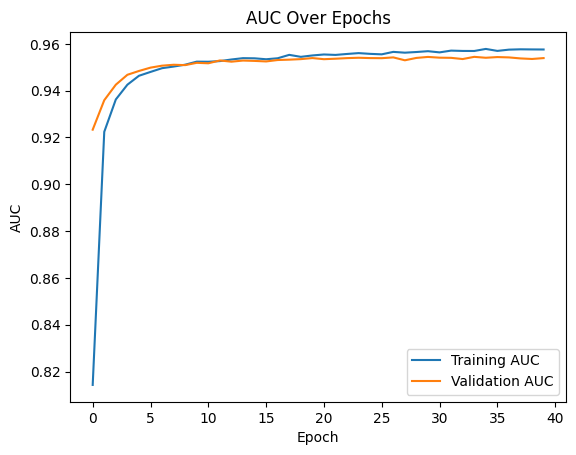

In [26]:
train_auc = ann_model_history.history['auc']
val_auc = ann_model_history.history['val_auc']

# Plot AUC metric
plt.plot(train_auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC Over Epochs')
plt.legend()
plt.show()

In [27]:
predictions = ann_model.predict(X_test.to_pandas())

4303/4303 [==============================] - 9s 2ms/step


In [28]:
ann_comp = amex_metric_mod(y_test.to_numpy(), predictions.flatten())
ann_accuracy = cuml.metrics.accuracy_score(y_test, predictions.flatten())
print(f" ANN Scores \n ------------------------------------- \n Accuracy: {ann_accuracy} \n Competition Metric: {ann_comp}")

/usr/local/lib/python3.10/dist-packages/cupy/cuda/compiler.py:233: PerformanceWarning: Jitify is performing a one-time only warm-up to populate the persistent cache, this may take a few seconds and will be improved in a future release...
  jitify._init_module()


 ANN Scores 
 ------------------------------------- 
 Accuracy: 0.741031289100647 
 Competition Metric: 0.7678825122134977
